In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

In [11]:
from sklearn.preprocessing import MinMaxScaler


In [12]:
df = pd.read_csv('GMD.csv')

Variables to use: Country, year, rGDP_USD, imports_GDP, (Δ) governement debt, (Δ) M2, infl, unemp, cbrate, ltrate

In [27]:
api_key = 'e4bbbd109c546c1661986ae1b4815d17'  
fred = Fred(api_key=api_key)

# Dictionary of countries and their corresponding FRED series IDs for Consumer Confidence
consumer_confidence_series = {
    'Australia': 'CSCICP02AUM460S',
    'United Kingdom': 'CSCICP02GBM460S',
    'Japan': 'CSCICP02JPM460S',
    'Korea': 'CSCICP02KRA066S',
    'New Zealand': 'LOCOCIORNZQ665S',
    'United States': 'USALOCOCINOSTSAM',
    'Canada': 'CSCICP02CAM661N',  
    'Italy': 'CSCICP02ITM460S',
    'Portugal': 'CSCICP02PTM460S',
    'Turkey': 'CSCICP02TRM460S',
    'Brazil': 'CSCICP02BRM460S',
    'Czechia': 'CSCICP02CZM460S',
    'Switzerland': 'CSCICP02CHQ460S',
    'Germany': 'CSCICP02DEM460S',
    'France': 'CSCICP02FRM460S',
    'Mexico': 'CSCICP02MXM460S',
    'Russia': 'RUSCSCICP02STSAQ',
    'Spain': 'CSCICP02ESM460S',
    'Sweden': 'CSCICP02SEM460S',
    'Denmark': 'CSCICP02DKM460S',
    'Netherlands': 'CSCICP02NLM460S',  
    'China': 'CSCICP02CNM460S', 
}


data = {}
for country, series_id in consumer_confidence_series.items():
    data[country] = fred.get_series(series_id)
    
consumer_data = pd.DataFrame(data)

consumer_data_yearly = consumer_data.resample('YE').mean()

consumer_data_yearly.index = consumer_data_yearly.index.year

consumer_data_panel = consumer_data_yearly.reset_index().melt(id_vars='index', var_name='Country', value_name='Consumer_Confidence')
consumer_data_panel.rename(columns={'index': 'Year'}, inplace=True)

consumer_data_panel.dropna(inplace=True)




In [28]:
df_filtered = df[['countryname', 'year', 'rGDP_USD', 'imports_GDP', 'govdebt_GDP', 'M2', 'infl', 'unemp', 'cbrate', 'ltrate']]

df_filtered['Δ_govdebt_GDP'] = df_filtered.groupby('countryname')['govdebt_GDP'].pct_change() * 100
df_filtered['Δ_M2'] = df_filtered.groupby('countryname')['M2'].pct_change() * 100

/var/folders/ts/x847bxb170n3msnnpmdpjll00000gn/T/ipykernel_87205/2305044187.py:3: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_filtered['Δ_govdebt_GDP'] = df_filtered.groupby('countryname')['govdebt_GDP'].pct_change() * 100
/var/folders/ts/x847bxb170n3msnnpmdpjll00000gn/T/ipykernel_87205/2305044187.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Δ_govdebt_GDP'] = df_filtered.groupby('countryname')['govdebt_GDP'].pct_change() * 100
/var/folders/ts/x847bxb170n3msnnpmdpjll00000gn/T/ipykernel_87205/2305044187.py:4: FutureWarn

In [29]:
df_filtered['Country'] = df_filtered['countryname']
df_filtered = df_filtered.drop('countryname', axis=1)

merged_df_before = pd.merge(df_filtered, consumer_data_panel, left_on=['year', 'Country'], right_on=['Year', 'Country'], how='inner')


/var/folders/ts/x847bxb170n3msnnpmdpjll00000gn/T/ipykernel_87205/2588897887.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Country'] = df_filtered['countryname']


In [30]:
merged_df_before = merged_df_before.dropna()

In [31]:
def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.05)
        Q3 = df[column].quantile(0.80)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

columns_to_check = ['Consumer_Confidence','infl','unemp','Δ_govdebt_GDP','Δ_M2']

merged_df = remove_outliers(merged_df_before, columns_to_check)

In [32]:
merged_df.dropna(inplace=True)
#merged_df.drop(['Year'], axis=1, inplace=True)
merged_df[merged_df['year'] <= 2019]

,year,rGDP_USD,imports_GDP,govdebt_GDP,M2,infl,unemp,cbrate,ltrate,Δ_govdebt_GDP,Δ_M2,Country,Year,Consumer_Confidence
1,1975,355049.81,14.711743,23.640409,3.194215e+04,15.162456,4.878655,8.400,9.741667,5.680190,20.559141,Australia,1975,5.250000
2,1976,368675.72,13.361888,22.985813,3.584829e+04,13.322886,4.749999,7.200,10.030833,-2.768971,12.228765,Australia,1976,7.416667
3,1977,374142.38,14.630217,23.642473,3.797083e+04,12.309813,5.604135,7.910,10.226666,2.856806,5.920916,Australia,1977,4.166667
4,1978,381696.06,14.570860,22.087608,4.195406e+04,8.004933,6.290086,8.280,9.060000,-6.576575,10.490239,Australia,1978,6.916667
5,1979,399204.50,15.335192,22.801823,4.682468e+04,9.122004,6.264902,8.000,9.749166,3.233555,11.609395,Australia,1979,0.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,2015,18295000.00,15.277065,104.661000,1.177420e+07,0.118625,5.275000,0.375,2.135833,0.401949,5.905951,United States,2015,100.700151
776,2016,18627894.00,14.564439,106.582000,1.249080e+07,1.261581,4.875000,0.625,1.841667,1.835450,6.086188,United States,2016,99.750329
777,2017,19085692.00,14.947857,105.529000,1.328640e+07,2.136000,4.358000,1.375,2.330000,-0.987972,6.369488,United States,2017,100.358599
778,2018,19651900.00,15.158248,106.847000,1.386920e+07,2.440000,3.892000,2.375,2.910000,1.248946,4.386440,United States,2018,100.742298


In [65]:
bin_edges = [-np.inf,0, 5,np.inf]  # Inflation bin ranges
bin_labels = ['Disinflation', 'Target', 'High']  # Inflation bin labels
merged_df['inflation_bin'] = pd.cut(merged_df['infl'], bins=bin_edges, labels=bin_labels)

X_knn = merged_df[['imports_GDP', 'Δ_govdebt_GDP', 'Δ_M2', 'unemp', 'cbrate', 'ltrate', 'rGDP_USD']]
Y_knn = merged_df['inflation_bin']

label_encoder = LabelEncoder()
Y_knn_encoded = label_encoder.fit_transform(Y_knn)

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_knn, Y_knn_encoded)

merged_df['knn_pred_bin'] = knn_model.predict(X_knn)
bin_stats.to_csv('bin_stats.csv', index=True)

print(bin_stats)

                   infl                                           rGDP_USD  \
                   mean       std       min        max count          mean   
inflation_bin                                                                
Disinflation  -0.390878  0.347695 -1.352839  -0.008571    32  2.802843e+06   
Target         2.153819  1.184636  0.017947   4.960717   420  2.799866e+06   
High           8.405425  2.645622  5.030737  15.162456   123  1.438421e+06   

                            imports_GDP            govdebt_GDP             \
                        std        mean        std        mean        std   
inflation_bin                                                               
Disinflation   2.974749e+06   27.178966  17.705077  124.018266  72.570749   
Target         4.360428e+06   30.235175  13.622300   63.657811  38.604676   
High           2.396126e+06   23.838098  10.074644   44.367222  25.756474   

                  unemp           Consumer_Confidence             
 

In [33]:
columns_to_normalize = merged_df.columns.difference(['year', 'Country'])

scaler = MinMaxScaler()
merged_df[columns_to_normalize] = scaler.fit_transform(merged_df[columns_to_normalize])

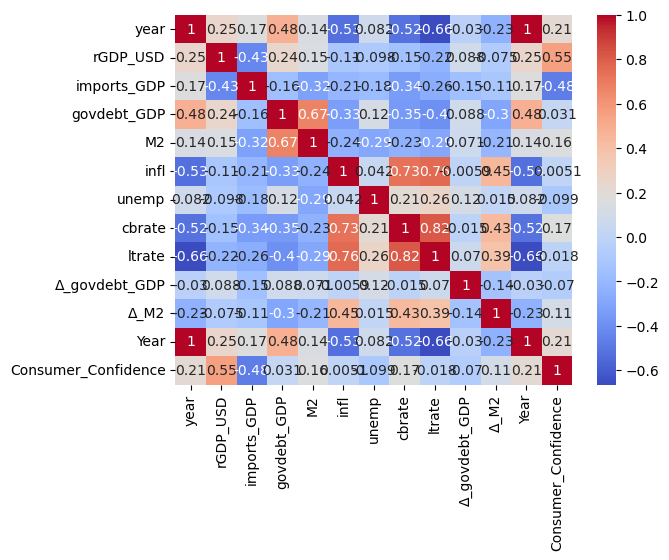

In [34]:
df_filtered_numeric = merged_df.select_dtypes(include=[np.number])

sns.heatmap(df_filtered_numeric.corr(), annot=True, cmap='coolwarm')
plt.show()

Variables with over |.15| correlation --> Just for inital data exploration
rGDP & importsGDP --> Not surprising: more $, more imports
rGDP & govdebt -> Rich 'exceptionalism', those with bigger economies can afford debt
govdebt & LT_Rate, cbRate, infl --> Not Δ, but this could be important for FTPL
infl & cbrate, lt_rate --> adjusts for value, is expected
unemp & lt_rate --> Postive, expected, following phillips curve


To Do:
Identify Countries as developed or developing 

Identify if the information for consumer sentimenet is 'contained' within all other datapoints
    --> Indexed? Percent Change? normalization?

Scale all variables

Use KNN to determine bins
    --> before or after normalization?

In [35]:
descriptive_stats = df_filtered_numeric.describe()

In [36]:
df_filtered = merged_df
len(df_filtered)

575

In [37]:
df_filtered = df_filtered[df_filtered['year'] <= 2019]
len(df_filtered)

550

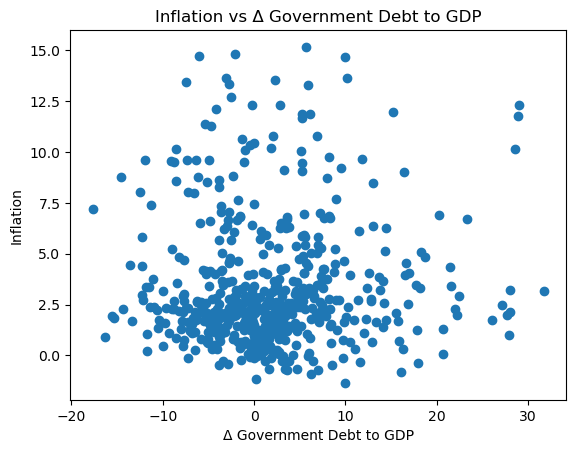

In [38]:
plt.scatter(df_filtered['Δ_govdebt_GDP'], df_filtered['infl'])
plt.xlabel('Δ Government Debt to GDP')
plt.ylabel('Inflation')
plt.title('Inflation vs Δ Government Debt to GDP')
plt.show()

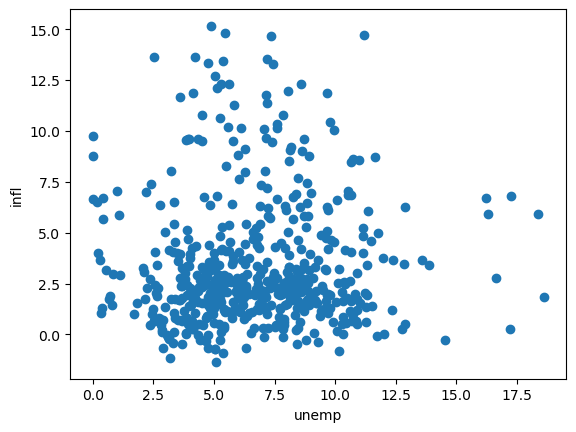

In [39]:
plt.scatter(df_filtered['unemp'], df_filtered['infl'])
plt.ylabel('infl')
plt.xlabel('unemp')
plt.show()

## Hide


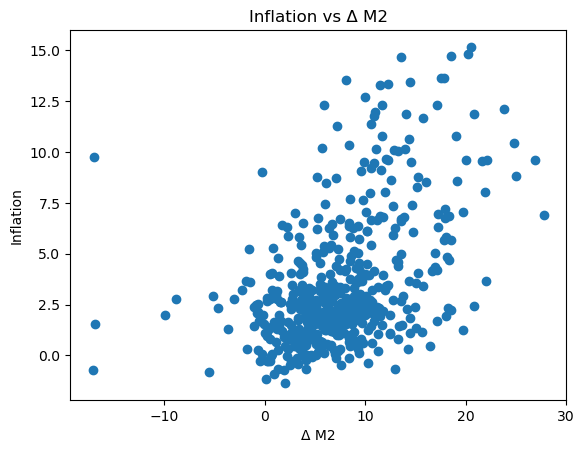

In [40]:
plt.scatter(df_filtered['Δ_M2'], df_filtered['infl'])   
plt.xlabel('Δ M2')
plt.ylabel('Inflation')
plt.title('Inflation vs Δ M2')
plt.show()

In [41]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variable"] = df_filtered_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(df_filtered_numeric.values, i) for i in range(len(df_filtered_numeric.columns))]

vif_data

/Users/dannyhogan/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Variable,VIF
0,year,inf
1,rGDP_USD,3.042981
2,imports_GDP,13.587004
3,govdebt_GDP,10.462011
4,M2,3.951017
5,infl,6.595089
6,unemp,12.594606
7,cbrate,8.265289
8,ltrate,14.752603
9,Δ_govdebt_GDP,1.170449


# Regression to determine 'Information Inclusion' of Consumer Sentiment

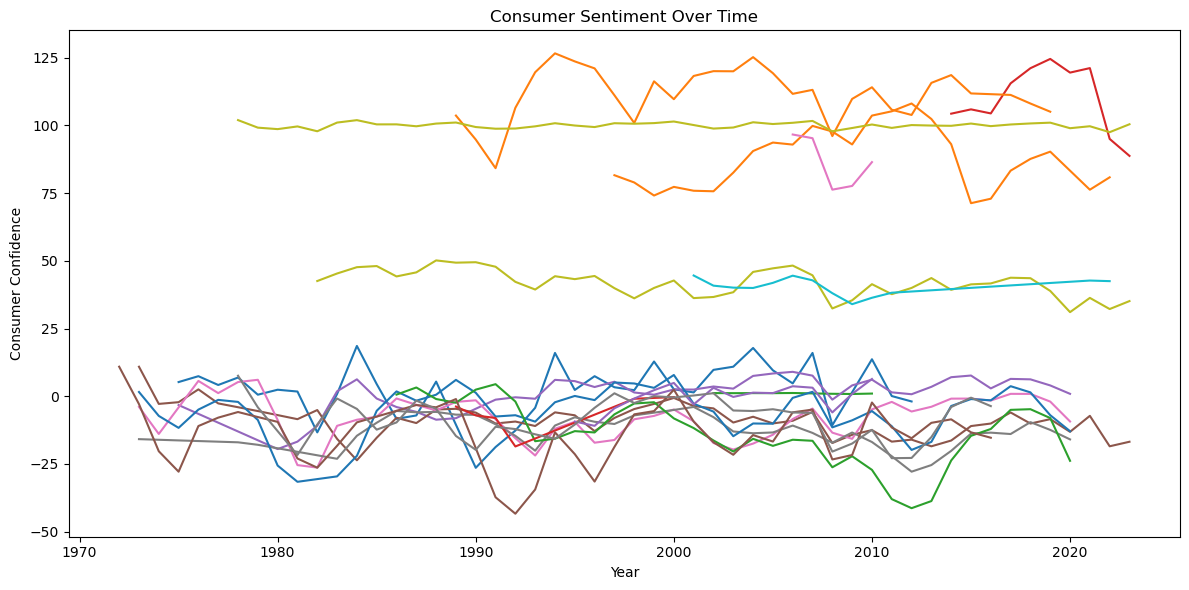

In [42]:
plt.figure(figsize=(12, 6))
for country in merged_df['Country'].unique():
    country_data = merged_df[merged_df['Country'] == country]
    plt.plot(country_data['Year'], country_data['Consumer_Confidence'], label=country)

plt.xlabel('Year')
plt.ylabel('Consumer Confidence')
plt.title('Consumer Sentiment Over Time')
plt.tight_layout()
plt.show()

In [43]:
X = merged_df.drop(columns=['Country', 'Year', 'Consumer_Confidence', 'Consumer_Confidence_Indexed'])
y = merged_df['Consumer_Confidence_Indexed']
y = y.loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=82)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(mse)
print(r2)

KeyError: "['Consumer_Confidence_Indexed'] not found in axis"

Conclusion: Don't have nearly enough information, could try another way, bt I think that this is a good baseline.

# Causal Forest

In [44]:
from econml.dml import CausalForestDML
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso

In [105]:
from econml.dml import maringal_effect_interval

ImportError: cannot import name 'maringal_effect_interval' from 'econml.dml' (/Users/dannyhogan/anaconda3/lib/python3.11/site-packages/econml/dml/__init__.py)

In [45]:
import numpy as np
from itertools import product
from sklearn.linear_model import Lasso, LogisticRegression
import matplotlib.pyplot as plt
import os
import pandas as pd
import urllib.request
from sklearn.preprocessing import StandardScaler

In [46]:
n_trees = 1000
min_leaf_size = 50
max_depth = 20
subsample_ratio = 0.04

In [47]:
merged_df = merged_df.dropna()

In [93]:
n_trees = 1000
min_leaf_size = 50
max_depth = 20
subsample_ratio = 0.04

Y = merged_df['infl']
T1 = merged_df['unemp']
T2 = merged_df['Δ_govdebt_GDP']
T3 = merged_df['Δ_M2']
scaler = StandardScaler()

W1 = scaler.fit_transform(merged_df[['Δ_govdebt_GDP','Δ_M2','cbrate', 'ltrate']])
X1 = merged_df[['Consumer_Confidence','imports_GDP','rGDP_USD' ]]

W2 = scaler.fit_transform(merged_df[['unemp','Δ_M2','cbrate', 'ltrate']])
X2 = merged_df[['Consumer_Confidence','imports_GDP','rGDP_USD' ]]


W3 = scaler.fit_transform(merged_df[['unemp','Δ_govdebt_GDP','cbrate', 'ltrate']])
X3 = merged_df[['Consumer_Confidence','imports_GDP','rGDP_USD' ]]


est = CausalForestDML(model_y=WeightedLassoCVWrapper(cv=3, n_jobs=-1, random_state=123),
                        model_t=WeightedLasso(alpha=0.01),
                        discrete_treatment=False,
                        n_estimators=n_trees,
                        min_samples_leaf=min_leaf_size,
                        max_depth=max_depth,
                        random_state=123)

In [100]:
NK_Tree = est.fit(Y,T1,X=X1, W=W1)
FTPL_Tree = est.fit(Y,T2,X=X2, W=W2)
M_Tree = est.fit(Y, T3, X=X3, W=W3)




Model <econml.sklearn_extensions.linear_model.WeightedLassoCVWrapper object at 0x179970f50> has a non-default cv attribute, which will be ignored
Model <econml.sklearn_extensions.linear_model.WeightedLassoCVWrapper object at 0x179e70490> has a non-default cv attribute, which will be ignored
Model <econml.sklearn_extensions.linear_model.WeightedLassoCVWrapper object at 0x179ea8190> has a non-default cv attribute, which will be ignored


In [94]:
def run_causal_forest(Y, T, X, W, W_cols, title):
    est = CausalForestDML(
        model_y=WeightedLassoCVWrapper(cv=3, n_jobs=-1, random_state=123),
        model_t=WeightedLasso(alpha=0.01),
        discrete_treatment=False,
        n_estimators=n_trees,
        min_samples_leaf=min_leaf_size,
        max_depth=max_depth,
        random_state=123
    )

    est.fit(Y, T, X=X, W=W)
    
    # Average treatment effect
    ate = est.effect(X).mean()
    print(f"\nEstimated ATE ({title}): {ate:.4f}")
    
    # Optional: visualize heterogeneity if you want
    return est, ate


In [95]:
est_NK, NK_CATE = run_causal_forest(Y, T1, X1, W1,
    W_cols=['imports_GDP','cbrate', 'ltrate', 'rGDP_USD' ,'Consumer_Confidence'],
    title='New Keynesian (T = unemp)'
)

est_FTPL, FTPL_CATE = run_causal_forest(Y, T2, X2, W2,
    W_cols=['imports_GDP','cbrate', 'ltrate', 'rGDP_USD' ,'Consumer_Confidence'],
    title='Fiscal Theory of Price Level (T = Δ_govdebt_GDP)'
)

est_M, M_CATE = run_causal_forest(Y, T3, X3, W3,
    W_cols=['imports_GDP','cbrate', 'ltrate', 'rGDP_USD' ,'Consumer_Confidence'],
    title='Monetarist (T = Δ_M2)'
)


Model <econml.sklearn_extensions.linear_model.WeightedLassoCVWrapper object at 0x179809650> has a non-default cv attribute, which will be ignored



Estimated ATE (New Keynesian (T = unemp)): -0.1565


Model <econml.sklearn_extensions.linear_model.WeightedLassoCVWrapper object at 0x179698e10> has a non-default cv attribute, which will be ignored



Estimated ATE (Fiscal Theory of Price Level (T = Δ_govdebt_GDP)): -0.0057


Model <econml.sklearn_extensions.linear_model.WeightedLassoCVWrapper object at 0x1799a9c90> has a non-default cv attribute, which will be ignored



Estimated ATE (Monetarist (T = Δ_M2)): 0.0672


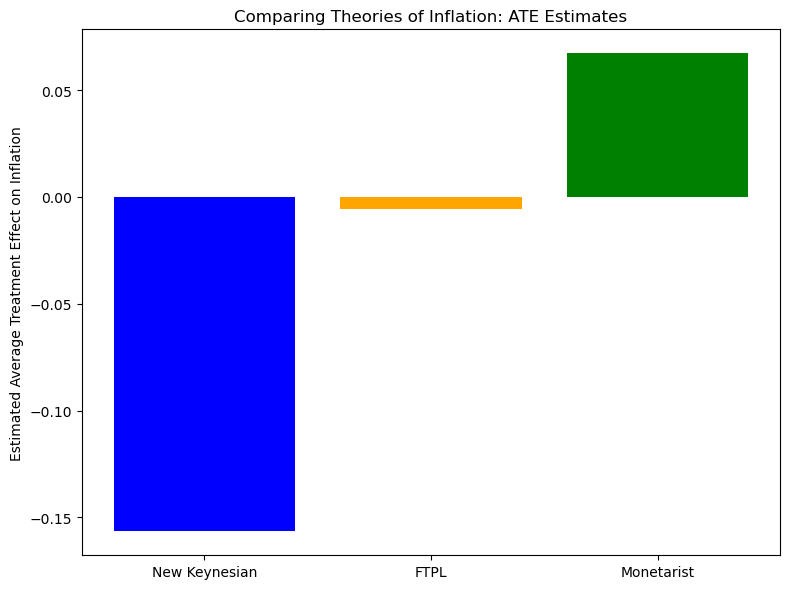

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.bar(['New Keynesian', 'FTPL', 'Monetarist'], [NK_CATE, FTPL_CATE, M_CATE],
        color=['blue', 'orange', 'green'])
plt.ylabel('Estimated Average Treatment Effect on Inflation')
plt.title('Comparing Theories of Inflation: ATE Estimates')
plt.tight_layout()
plt.show()


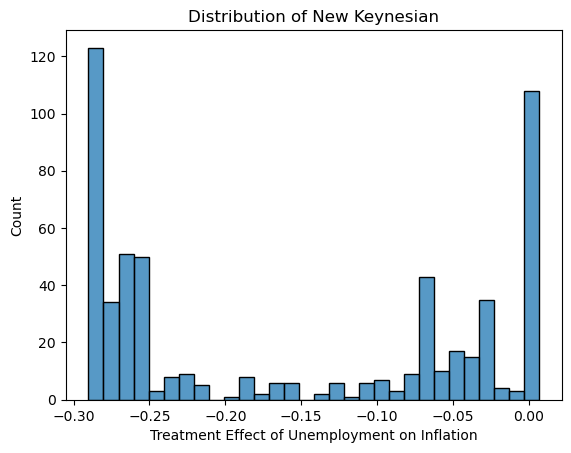

In [97]:
# e.g. NK model
individual_effects = est_NK.effect(X1)

# Plot distribution
import seaborn as sns
sns.histplot(individual_effects, bins=30)
plt.title("Distribution of New Keynesian")
plt.xlabel("Treatment Effect of Unemployment on Inflation")
plt.show()


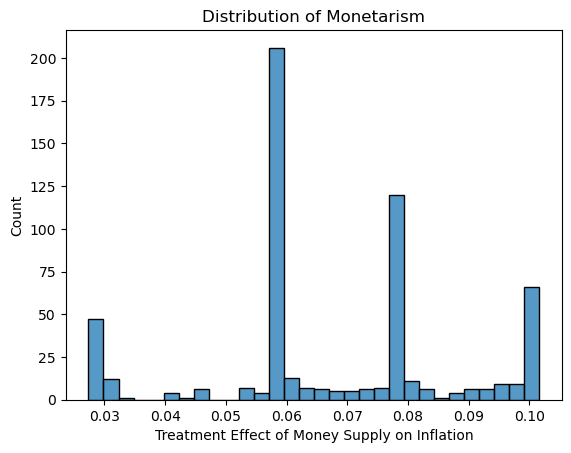

In [98]:
individual_effects = est_M.effect(X1)

# Plot distribution
import seaborn as sns
sns.histplot(individual_effects, bins=30)
plt.title("Distribution of Monetarism")
plt.xlabel("Treatment Effect of Money Supply on Inflation")
plt.show()


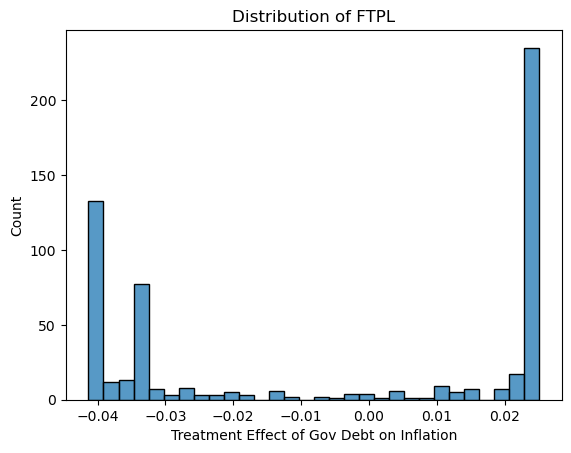

In [99]:
# e.g. NK model
individual_effects = est_FTPL.effect(X1)

# Plot distribution
import seaborn as sns
sns.histplot(individual_effects, bins=30)
plt.title("Distribution of FTPL")
plt.xlabel("Treatment Effect of Gov Debt on Inflation")
plt.show()


In [104]:
bounds_NK  = marginal_ate_interval(T = T1)

NameError: name 'marginal_ate_interval' is not defined